In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
import glob
import gc
import functools
from multiprocessing import Pool, cpu_count
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns=100
pd.options.display.max_rows=1000


In [2]:
ROOT_DIR = '../data/instacart/files/'

#### Loading files

In [3]:
print('loading prior')
priors = pd.read_csv(ROOT_DIR+'order_products__prior.csv', dtype={
    'order_id':np.int32,
    'product_id':np.uint16,
    'add_to_cart_order':np.int16,
    'reordered':np.int8
})

print('loading train')
train = pd.read_csv(ROOT_DIR+'order_products__train.csv', dtype={
    'order_id':np.int32,
    'product_id':np.uint16,
    'add_to_cart_order':np.int16,
    'reordered':np.int8
})

print('loading orders')
orders = pd.read_csv(ROOT_DIR+'orders.csv', dtype={
    'order_id':np.int32,
    'user_id':np.int32,
    'eval_set':'category',
    'order_number':np.int16,
    'order_dow':np.int8,
    'order_hour_of_day':np.int8,
    'days_since_prior_order':np.float32
})

print('loading products')
products = pd.read_csv(ROOT_DIR+'products.csv', dtype={
    'product_id':np.uint16,
    'aisle_id':np.int32,
    'department_id':np.uint8}, usecols=['product_id', 'aisle_id', 'department_id'])

print('priors {}:{}'.format(priors.shape, ','.join(priors.columns)))
print('orders {}:{}'.format(orders.shape, ','.join(orders.columns)))
print('train {}:{}'.format(train.shape, ','.join(train.columns)))


loading prior
loading train
loading orders
loading products
priors (32434489, 4):order_id,product_id,add_to_cart_order,reordered
orders (3421083, 7):order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
train (1384617, 4):order_id,product_id,add_to_cart_order,reordered


#### Joining and Preprocessing

In [4]:
print('add orders info to priors and train')
orders.set_index('order_id', inplace=True, drop=False)
orders['last_order_number'] = orders.groupby('user_id')['order_number'].transform(max)
orders['order_number_reverse'] = orders['last_order_number'] - orders['order_number']
orders.drop('last_order_number', axis=1, inplace=True)
orders['cumulative_time'] = orders.groupby('user_id')['days_since_prior_order'].transform('cumsum')
orders.cumulative_time.fillna(0, inplace=True)

priors = priors.join(orders, on='order_id', rsuffix='_')
priors.drop('order_id_', inplace=True, axis=1)
priors = pd.merge(priors, products, on='product_id', how='left')
priors['order_basket_size'] = priors.groupby('order_id')['add_to_cart_order'].transform('max')
priors['order_reordered_prods'] = priors.groupby('order_id')['reordered'].transform('sum')
priors['user_product'] = priors.product_id + priors.user_id*100000
priors['user_aisle'] = priors.user_id.map(str) + priors.aisle_id.map(str)
priors['user_aisle'] = priors.user_aisle.map(int)
priors.sort_values(['user_product', 'order_number'], inplace=True)
priors['user_product_shift'] = priors.user_product.shift()
priors['UP_consecutive_diff'] = priors.cumulative_time - priors.cumulative_time.shift()
priors['UP_consecutive_order_diff'] = priors.order_number - priors.order_number.shift()
priors.loc[priors.user_product!=priors.user_product_shift, 'UP_consecutive_diff'] = np.NaN
priors.loc[priors.user_product!=priors.user_product_shift, 'UP_consecutive_order_diff'] = np.NaN
priors.drop('user_product_shift', inplace=True, axis=1)


train = train.join(orders, on='order_id', rsuffix='_')
train.drop('order_id_', inplace=True, axis=1)
train = pd.merge(train, products, on='product_id', how='left')
train['order_basket_size'] = train.groupby('order_id')['add_to_cart_order'].transform('max')
train['order_reordered_prods'] = train.groupby('order_id')['reordered'].transform('sum')

# hack-around for user-order features
orders = pd.merge(orders, priors[['order_id', 'order_basket_size', 'order_reordered_prods']].drop_duplicates('order_id'), on='order_id', how='left')
orders.set_index('order_id', inplace=True, drop=False)


add orders info to priors and train


In [5]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,order_number_reverse,cumulative_time,order_basket_size,order_reordered_prods
order_id,,,,,,,,,,,
2539329,2539329,1,prior,1,2,8,NaN,10,0.0,5.0,0.0
2398795,2398795,1,prior,2,3,7,15.0,9,15.0,6.0,3.0
473747,473747,1,prior,3,3,12,21.0,8,36.0,5.0,3.0
2254736,2254736,1,prior,4,4,7,29.0,7,65.0,5.0,5.0
431534,431534,1,prior,5,4,15,28.0,6,93.0,8.0,5.0


#### Functions for features

In [6]:
def get_product_features(n, reference_df, include_recent=False):
    if not include_recent:
        order_ids = orders.loc[(orders.order_number_reverse > n), 'order_id']
    else:
        order_ids = orders.loc[(orders.order_number_reverse > n)&(orders.order_number_reverse < 10), 'order_id']
    
    current = reference_df[reference_df.order_id.isin(order_ids)]
    grouped_df = current.groupby(current.product_id)
    prods = pd.DataFrame()
    prods['product_orders'] = grouped_df.size().astype(np.int32)
    prods['product_reorders'] = grouped_df['reordered'].sum().astype(np.float32)
    prods['product_reorder_rate'] = prods.product_reorders/prods.product_orders
    prods['product_avg_dow'] = grouped_df['order_dow'].mean().astype(np.float32)
    prods['product_avg_hour'] = grouped_df['order_hour_of_day'].mean().astype(np.float32)
    prods['product_avg_add_to_cart_order'] = grouped_df['add_to_cart_order'].mean().astype(np.float32)
    prods['product_avg_days_since_prior_order'] = grouped_df['days_since_prior_order'].mean().astype(np.float32)
    prods['product_popularity'] = grouped_df['user_id'].nunique().astype(np.int32)
    prods['product_avg_time_since_last'] = grouped_df['UP_consecutive_diff'].mean().astype(np.float32)
    prods['product_std_time_since_last'] = grouped_df['UP_consecutive_diff'].std().astype(np.float32)
    prods['product_avg_orders_since_last'] = grouped_df['UP_consecutive_order_diff'].mean().astype(np.float32)
    prods['product_std_orders_since_last'] = grouped_df['UP_consecutive_order_diff'].std().astype(np.float32)

    if not include_recent:
        prods['product_total_basket_items'] = grouped_df['order_basket_size'].sum().astype(np.int32)
        prods['product_avg_basket_size'] = grouped_df['order_basket_size'].mean().astype(np.float32)
        prods['product_basket_reorders'] = grouped_df['order_reordered_prods'].sum().astype(np.float32)
        prods['product_basket_reorder_rate'] = prods.product_basket_reorders/prods.product_total_basket_items
    prods.loc[~(prods.product_avg_time_since_last.isnull())&(prods.product_std_time_since_last.isnull()), 'product_std_time_since_last'] = 1000
    prods['product_avg_time_since_last'].fillna(10000, inplace=True)
    prods['product_std_time_since_last'].fillna(10000, inplace=True)
    
    prods.loc[~(prods.product_avg_orders_since_last.isnull())&(prods.product_std_orders_since_last.isnull()), 'product_std_orders_since_last'] = 1000
    prods['product_avg_orders_since_last'].fillna(10000, inplace=True)
    prods['product_std_orders_since_last'].fillna(10000, inplace=True)
    prods['product_avg_days_since_prior_order'].fillna(10000, inplace=True)
    
    prods.reset_index(inplace=True)
    prods = pd.merge(prods, products, on='product_id', how='left')
    return prods
    

In [7]:
def get_product_hour_dow_features(n, reference_df, include_recent=False):
    if not include_recent:
        order_ids = orders.loc[(orders.order_number_reverse > n), 'order_id']
    else:
        order_ids = orders.loc[(orders.order_number_reverse > n)&(orders.order_number_reverse < 10), 'order_id']
    
    current = reference_df[reference_df.order_id.isin(order_ids)]
    grouped_df = current.groupby(['product_id', 'order_dow'])    
    prod_dow = pd.DataFrame()
    prod_dow['product_dow_orders'] = grouped_df.size().astype(np.int32)
    prod_dow['product_dow_reorders'] = grouped_df['reordered'].sum().astype(np.float32)
    prod_dow['product_dow_reorder_rate'] = prod_dow.product_dow_reorders/prod_dow.product_dow_orders
    prod_dow['product_dow_popularity'] = grouped_df['user_id'].nunique().astype(np.int32)
    prod_dow = prod_dow.reset_index()
    return prod_dow

In [8]:
def get_aisle_features(n, reference_df, include_recent=False):
    if not include_recent:
        order_ids = orders.loc[orders.order_number_reverse>n, 'order_id']
    else:
        order_ids = orders.loc[(orders.order_number_reverse>n)&(orders.order_number_reverse<10), 'order_id']
    current = reference_df[reference_df.order_id.isin(order_ids)]
    grouped_df = current.groupby('aisle_id')
    aisles = pd.DataFrame()
    aisles['aisle_orders'] = grouped_df.size().astype(np.int32)
    aisles['aisle_reorders'] = grouped_df['reordered'].sum().astype(np.float32)
    aisles['aisle_reorder_rate'] = aisles.aisle_reorders/aisles.aisle_orders
    aisles['aisle_avg_dow'] = grouped_df['order_dow'].mean().astype(np.float32)
    aisles['aisle_avg_hour'] = grouped_df['order_hour_of_day'].mean().astype(np.float32)
    aisles['aisle_avg_add_to_cart_order'] = grouped_df['add_to_cart_order'].mean().astype(np.float32)
    aisles['aisle_avg_days_since_prior_order'] = grouped_df['days_since_prior_order'].mean().astype(np.float32)
    aisles['aisle_popularity'] = grouped_df['user_id'].nunique().astype(np.int32)
    aisles['aisle_unique_prods'] = grouped_df['product_id'].nunique().astype(np.int32)
    aisles.reset_index(inplace=True)
    return aisles

In [9]:
def get_dow_hour_features(n, reference_df, include_recent=False):
    if not include_recent:
        order_ids = orders.loc[orders.order_number_reverse>n, 'order_id']
    else:
        order_ids = orders.loc[(orders.order_number_reverse>n)&(orders.order_number_reverse<10), 'order_id']
    current = orders[orders.order_id.isin(order_ids)]
    grouped_df = current.groupby(['order_dow', 'order_hour_of_day'])
    dow_hour = pd.DataFrame()
    dow_hour['dow_hour_orders'] = grouped_df.size().astype(np.int32)
    dow_hour.reset_index(inplace=True)
    #dow_hour features
    current = reference_df[reference_df.order_id.isin(order_ids)]
    grouped_df = current.groupby(['order_dow', 'order_hour_of_day'])
    dow_hour_feat = pd.DataFrame()
    dow_hour_feat['dow_hour_products'] = grouped_df.size().astype(np.int32)
    dow_hour_feat['dow_hour_reorders'] = grouped_df['reordered'].sum().astype(np.float32)
    dow_hour_feat['dow_hour_reorder_rate'] = dow_hour_feat.dow_hour_reorders/dow_hour_feat.dow_hour_products
    dow_hour_feat['dow_hour_unique_products'] = grouped_df['product_id'].nunique().astype(np.int32)
    dow_hour_feat.reset_index(inplace=True)
    dow_hour_feat = pd.merge(dow_hour_feat, dow_hour, on=['order_dow', 'order_hour_of_day'])
    return dow_hour_feat

In [10]:
def get_lag_feat(lag, n, reference_df):
    U_last = reference_df[reference_df.order_number_reverse>n].groupby('user_id')['order_number'].aggregate('max').reset_index()
    U_last.order_number -= lag 
    U_last = pd.merge(reference_df[reference_df.order_number_reverse>n][['user_id', 'order_number',
                    'add_to_cart_order']], U_last, on=['user_id', 'order_number'])
    lag_feat = U_last.groupby('user_id')['add_to_cart_order'].aggregate('max')
    lag_feat.name = 'basket_size_in_last{}_order'.format(lag)
    return lag_feat

In [11]:
def get_user_features(n, reference_df, eval_set='prior', include_recent=False):
    if not include_recent:
        current = orders[(orders.order_number_reverse>n)]
    else:
        current = orders[(orders.order_number_reverse>n)&(orders.order_number_reverse<10)]
    grouped_df = current.groupby('user_id')
    usr = grouped_df.aggregate({'days_since_prior_order':'mean','order_number':'max','order_dow':'mean'})
    usr.rename(columns={'days_since_prior_order':'user_average_days_between_orders','order_number':'user_nb_orders',
                       'order_dow':'user_average_order_dow'}, inplace=True)
    usr['user_average_days_between_orders'] = usr['user_average_days_between_orders'].astype(np.float32)
    usr['user_nb_orders'] = usr['user_nb_orders'].astype(np.int16)
    usr['user_average_order_dow'] = usr['user_average_order_dow'].astype(np.int8)
    usr['user_std_days_between_orders'] = grouped_df['days_since_prior_order'].aggregate('std').values

    users = pd.DataFrame()
    if not include_recent:
        current = reference_df[reference_df.order_number_reverse>n].groupby('user_id')
    else:
        current = reference_df[(reference_df.order_number_reverse>n)&(reference_df.order_number_reverse<10)].groupby('user_id')
    users['user_total_items'] = current.size().astype(np.int16)
    users['user_all_products'] = current['product_id'].apply(set)
    users['user_total_distinct_items'] = users['user_all_products'].apply(len).astype(np.int16)
    users['user_reorder_rate'] = current['reordered'].aggregate(sum)/users['user_total_items']
    users['user_reorders'] = current['reordered'].aggregate(sum)
    users.drop('user_all_products', axis=1, inplace=True)
    users = users.join(usr)
    users.reset_index(drop=False, inplace=True)
    users['user_average_basket_size'] = (users['user_total_items']/users['user_nb_orders']).astype(np.float32)
    
    if not include_recent:
        lag_feat = get_lag_feat(0, n, reference_df)
        users = users.join(lag_feat, on='user_id')
        lag_feat = get_lag_feat(1, n, reference_df)
        users = users.join(lag_feat, on='user_id')
    return users

In [12]:
def get_lag_feat(lag, n, reference_df):
    U_last = reference_df[reference_df.order_number_reverse>n].groupby('user_id')['order_number'].aggregate('max').reset_index()
    U_last.order_number -= lag 
    U_last = pd.merge(reference_df[reference_df.order_number_reverse>n], U_last, on=['user_id', 'order_number'])
    lag_feat = U_last.groupby('user_id')
    lag_df = pd.DataFrame()
    lag_df['user_basket_size_in_last{}_order'.format(lag)] = lag_feat['add_to_cart_order'].max().astype(np.int32)
    lag_df['user_days_since_prior_order_lag{}'.format(lag)] = lag_feat['days_since_prior_order'].mean().astype(np.int32)
    lag_df['user_order_dow_lag{}'.format(lag)] = lag_feat['order_dow'].mean().astype(np.int32)
    lag_df['user_hour_of_day_lag{}'.format(lag)] = lag_feat['order_hour_of_day'].mean().astype(np.int32)
    lag_df['user_reordered_lag{}'.format(lag)] = lag_feat['reordered'].sum().astype(np.int32)
    return lag_df
    
    

In [13]:
def get_user_features(n, reference_df, include_recent=False):
    #### Building user_order features
    if not include_recent:
        current = orders[(orders.order_number_reverse>n)]
    else:
        current = orders[(orders.order_number_reverse>n)&(orders.order_number_reverse<10)]
    grouped_df = current.groupby('user_id')
    usr = pd.DataFrame()
    usr['user_average_days_between_orders'] = grouped_df['days_since_prior_order'].mean().astype(np.float32)
    usr['user_nb_orders'] = grouped_df['order_number'].max().astype(np.int32)
    usr['user_average_order_dow'] = grouped_df['order_dow'].mean().astype(np.float32)
    usr['user_std_days_between_orders'] = grouped_df['days_since_prior_order'].std().astype(np.float32)
    usr['user_std_basket_size'] = grouped_df['order_basket_size'].std()
    usr['user_std_order_reordered_prods'] = grouped_df['order_reordered_prods'].std()

    #### Building user features
    users = pd.DataFrame()
    if not include_recent:
        current = reference_df[reference_df.order_number_reverse>n].groupby('user_id')
    else:
        current = reference_df[(reference_df.order_number_reverse>n)&(reference_df.order_number_reverse<10)].groupby('user_id')
    
    users = pd.DataFrame()
    users['user_total_items'] = current.size().astype(np.float32)
    users['user_total_distinct_items'] = current['product_id'].nunique().astype(np.int32)
    users['user_reorders'] = current['reordered'].sum().astype(np.float32)
    users['user_reorder_rate'] = users.user_reorders/users.user_total_items
    users['user_avg_product_diversity'] = users.user_total_distinct_items/users.user_total_items
    users = users.join(usr)
    users.reset_index(drop=False, inplace=True)
    users['user_average_basket_size'] = (users['user_total_items']/users['user_nb_orders']).astype(np.float32)
    users['user_avg_reorder_size'] = users.user_reorders/users.user_nb_orders
    
    if not include_recent:
        lag_feat = get_lag_feat(0, n, reference_df)
        users = users.join(lag_feat, on='user_id')
        lag_feat = get_lag_feat(1, n, reference_df)
        users = users.join(lag_feat, on='user_id')
    return users
        
            

In [14]:
def get_UP_days_since_features(n, reference_df, eval_set='prior', include_recent=False):
    if not include_recent:
        current = reference_df[(reference_df.order_number_reverse>n)]
    else:
        current = reference_df[(reference_df.order_number_reverse>n)&(reference_df.order_number_reverse<10)]
    grouped_df = current.groupby(['user_id', 'days_since_prior_order', 'product_id'])
    user_days_since_feat = pd.DataFrame()
    user_days_since_feat['UP_days_since_total_prods'] = grouped_df.size().astype(np.float32) 
    user_days_since_feat['UP_days_since_orders'] = grouped_df['order_id'].nunique().astype(np.int32)
    user_days_since_feat['UP_days_since_reordered'] = grouped_df['reordered'].sum().astype(np.float32)
    user_days_since_feat['UP_days_since_reorder_rate'] = user_days_since_feat.UP_days_since_reordered/user_days_since_feat.UP_days_since_total_prods
    #user_days_since_feat['UP_days_since_avg_basket'] = user_days_since_feat.user_days_since_total_prods/user_days_since_feat.user_days_since_orders
    user_days_since_feat = user_days_since_feat.reset_index()
    return user_days_since_feat

In [15]:
def get_user_order_features(n, reference_df, eval_set='prior', include_recent=False):
    if not include_recent:
        current = reference_df[(reference_df.order_number_reverse>n)]
    else:
        current = reference_df[(reference_df.order_number_reverse>n)&(reference_df.order_number_reverse<10)]
        
    grouped_df = current.groupby(['user_id', 'order_number'])
    user_order = pd.DataFrame()
    user_order['nb_none_orders'] = grouped_df['reordered'].sum()
    user_order.reset_index(inplace=True)
    user_order = user_order[user_order.nb_none_orders==0]
    user_order = user_order.groupby('user_id')['nb_none_orders'].count()
    user_order = user_order - 1
    user_order = user_order.reset_index()
    return user_order

In [16]:
def get_user_dow_features(n, reference_df, eval_set='prior', include_recent=False):
    if not include_recent:
        current = reference_df[(reference_df.order_number_reverse>n)]
    else:
        current = reference_df[(reference_df.order_number_reverse>n)&(reference_df.order_number_reverse<10)]
    grouped_df = current.groupby(['user_id', 'order_dow'])
    user_dow = pd.DataFrame()
    user_dow['user_dow_products'] = grouped_df.size().astype(np.int32)
    user_dow['user_dow_reorders'] = grouped_df['reordered'].sum().astype(np.float32)
    user_dow['user_dow_reorder_rate'] = user_dow.user_dow_reorders/user_dow.user_dow_products
    user_dow = user_dow.reset_index()
    return user_dow
    

In [17]:
def get_user_product_features(n, reference_df, eval_set='prior', include_recent=False):
    if not include_recent:
        grouped_df = reference_df[reference_df.order_number_reverse > n].groupby('user_product')
    else:
        grouped_df = reference_df[(reference_df.order_number_reverse > n)&(reference_df.order_number_reverse < 10)].groupby('user_product')
    
    userXproduct = grouped_df.aggregate({'user_product':'count', 'add_to_cart_order':'mean', 'order_number':'min', 'order_dow':'mean'})   
    userXproduct.rename(columns={'user_product':'UP_orders', 'add_to_cart_order':'UP_avg_pos_in_cart', 'order_number':'UP_first_order', 'order_dow':'UP_avg_order_dow'}, inplace=True)
    userXproduct['user_product'] = userXproduct.index.values
    userXproduct['UP_std_pos_in_cart'] = grouped_df['add_to_cart_order'].aggregate('std').values
    userXproduct['UP_total_basket_items'] = grouped_df['order_basket_size'].sum().astype(np.int32)
    userXproduct['UP_avg_basket_size'] = grouped_df['order_basket_size'].mean().astype(np.float32)
    userXproduct['UP_basket_reorders'] = grouped_df['order_reordered_prods'].sum().astype(np.float32)
    userXproduct['UP_basket_reorder_rate'] = userXproduct.UP_basket_reorders/userXproduct.UP_total_basket_items
    userXproduct.loc[userXproduct.UP_std_pos_in_cart.isnull(), 'UP_std_pos_in_cart'] = -1
    userXproduct['UP_avg_time_since_last'] = grouped_df['UP_consecutive_diff'].mean()
    userXproduct['UP_std_time_since_last'] = grouped_df['UP_consecutive_diff'].std()
    userXproduct['UP_avg_orders_since_last'] = grouped_df['UP_consecutive_order_diff'].mean() 
    userXproduct['UP_std_orders_since_last'] = grouped_df['UP_consecutive_order_diff'].std() 
    
    if not include_recent:
        grouped_df = reference_df[reference_df.order_number_reverse > n].groupby('user_product')['order_number'].aggregate('max').reset_index()
        grouped_df = pd.merge(grouped_df, reference_df.loc[reference_df.order_number_reverse > n, ['user_product', 'order_number', 'order_id']],
                          on=['user_product', 'order_number'], how='left')
        userXproduct = pd.merge(userXproduct, grouped_df,on='user_product', how='left')
        userXproduct.rename(columns={'order_id':'UP_last_order_id', 'order_number':'UP_last_order_number'}, inplace=True)
        grouped_df = reference_df[reference_df.order_number_reverse > n].groupby('user_product')['order_number'].aggregate('min').reset_index()
        grouped_df = pd.merge(grouped_df, reference_df.loc[reference_df.order_number_reverse > n, ['user_product', 'order_number', 'order_id']],
                          on=['user_product', 'order_number'], how='left')
        userXproduct = pd.merge(userXproduct, grouped_df,on='user_product', how='left')
        userXproduct.rename(columns={'order_id':'UP_first_order_id', 'order_number':'UP_first_order_number'}, inplace=True)
        userXproduct.drop('UP_first_order_number', axis=1, inplace=True)    
    
    ### additional UP features
    userXproduct.loc[(~userXproduct.UP_avg_time_since_last.isnull()) & (userXproduct.UP_std_time_since_last.isnull()), 'UP_std_time_since_last'] = 1000 
    userXproduct.UP_avg_time_since_last.fillna(10000, inplace=True)
    userXproduct.UP_std_time_since_last.fillna(10000, inplace=True)
    
    userXproduct.loc[(~userXproduct.UP_avg_orders_since_last.isnull()) & (userXproduct.UP_std_orders_since_last.isnull()), 'UP_std_orders_since_last'] = 1000
    userXproduct.UP_avg_orders_since_last.fillna(10000, inplace=True)
    userXproduct.UP_std_orders_since_last.fillna(10000, inplace=True)
    
    #userXproduct.index = userXproduct.user_product
    #userXproduct.drop(['order_number'], axis=1, inplace=True)
    return userXproduct

In [18]:
def get_user_aisle_features(n, reference_df, eval_set='prior', include_recent=False):
    if not include_recent:
        grouped_df = reference_df[reference_df.order_number_reverse > n].groupby('user_aisle')
    else:
        grouped_df = reference_df[(reference_df.order_number_reverse > n)&(reference_df.order_number_reverse < 10)].groupby('user_aisle')
    
    userXaisle = grouped_df.aggregate({'user_aisle':'count', 'add_to_cart_order':'mean', 'order_number':'min', 'order_dow':'mean'},)   
    userXaisle.rename(columns={'user_aisle':'UA_orders', 'add_to_cart_order':'UA_avg_pos_in_cart', 'order_number':'UA_first_order', 'order_dow':'UA_avg_order_dow'}, inplace=True)
    userXaisle['user_aisle'] = userXaisle.index.values
    userXaisle['UA_unique_prod_per_aisle'] = grouped_df['product_id'].nunique().astype(np.int32)
    
    if not include_recent:
        grouped_df = reference_df[reference_df.order_number_reverse > n].groupby('user_aisle')['order_number'].aggregate('max').reset_index()
        grouped_df = pd.merge(grouped_df, reference_df.loc[reference_df.order_number_reverse > n, ['user_aisle', 'order_number', 'order_id']],
                          on=['user_aisle', 'order_number'], how='left')
        userXaisle = pd.merge(userXaisle, grouped_df,on='user_aisle', how='left')
        userXaisle.rename(columns={'order_id':'UA_last_order_id', 'order_number':'UA_last_order_number'}, inplace=True)
        grouped_df = reference_df[reference_df.order_number_reverse > n].groupby('user_aisle')['order_number'].aggregate('min').reset_index()
        grouped_df = pd.merge(grouped_df, reference_df.loc[reference_df.order_number_reverse > n, ['user_aisle', 'order_number', 'order_id']],
                          on=['user_aisle', 'order_number'], how='left')
        userXaisle = pd.merge(userXaisle, grouped_df,on='user_aisle', how='left')
        userXaisle.rename(columns={'order_id':'UA_first_order_id', 'order_number':'UA_first_order_number'}, inplace=True)
        userXaisle.drop('UA_first_order_number', axis=1, inplace=True)    
    
    #userXproduct.index = userXproduct.user_product
    #userXproduct.drop(['order_number'], axis=1, inplace=True)
    return userXaisle.drop_duplicates('user_aisle')

In [18]:
def features(n, reference_df, selected_orders=False, labels_given=True):
    print('build candidate set')
    if labels_given:
        current_df = reference_df.loc[reference_df.order_number_reverse == n, ['user_id','product_id']]
        current_df['user_product'] = current_df.product_id + current_df.user_id*100000 
        candidate_df = priors.loc[(priors.order_number_reverse>n)&(priors.user_id.isin(current_df.user_id)), ['user_id', 'product_id', 'user_product']].drop_duplicates('user_product')
        labels = np.in1d(candidate_df.user_product, current_df.user_product).astype(int)
    else:
        current_df = reference_df
        candidate_df = priors.loc[(priors.order_number_reverse>n)&(priors.user_id.isin(current_df.user_id)),['user_id','product_id','user_product']].drop_duplicates('user_product')
        labels=None
    
    ### Building Features
    print('Building product features')
    #'product_id', 'product_orders', 'product_reorders', 'product_reorder_rate', 'aisle_id', 'department_id', 'product_popularity'
    product_features = get_product_features(n, priors)
    train_candidates = pd.merge(candidate_df, product_features, on='product_id',how='left')
    product_features = get_product_features(n, priors, include_recent=True)
    product_features.drop(['aisle_id', 'department_id'], axis=1, inplace=True)
    product_features.columns = ['product_id'] + map(lambda x: x +'_recent', product_features.columns[1:])
    train_candidates = pd.merge(train_candidates, product_features, on='product_id',how='left')
    train_candidates.loc[train_candidates.product_orders_recent.isnull(), 'product_orders_recent'] = 0
    train_candidates.loc[train_candidates.product_reorders_recent.isnull(), 'product_reorders_recent'] = 0.
    train_candidates.loc[train_candidates.product_reorder_rate_recent.isnull(), 'product_reorder_rate_recent'] = 0.
    train_candidates.loc[train_candidates.product_popularity_recent.isnull(), 'product_popularity_recent'] = 0
    train_candidates.loc[train_candidates.product_avg_dow_recent.isnull(), 'product_avg_dow_recent'] = -99.
    train_candidates.loc[train_candidates.product_avg_hour_recent.isnull(), 'product_avg_hour_recent '] = -99.
    train_candidates.loc[train_candidates.product_avg_add_to_cart_order_recent.isnull(), 'product_avg_add_to_cart_order_recent '] = -99.
    train_candidates.loc[train_candidates.product_avg_days_since_prior_order_recent.isnull(), 'product_avg_days_since_prior_order_recent'] = -99.
    
    del product_features
    
    print('Building aisle features')
    aisle_features = get_aisle_features(n, priors)    
        #Index([u'aisle_id', u'aisle_orders', u'aisle_reorders', u'aisle_reorder_rate',#  u'aisle_popularity']
    
    train_candidates = pd.merge(train_candidates, aisle_features, on='aisle_id', how='left')
    aisle_features = get_aisle_features(n, priors, include_recent=True)    
    aisle_features.columns = ['aisle_id'] + map(lambda x: x +'_recent', aisle_features.columns[1:])
    train_candidates = pd.merge(train_candidates, aisle_features, on='aisle_id', how='left')
    
        #train_candidates[aisle_features.columns[1:]].fillna(0, inplace=True)
    del aisle_features
    

    
    
    
    
    print('Building user features')
    user_features = get_user_features(n, priors)
    train_candidates = pd.merge(train_candidates, user_features, on='user_id', how='left')
    grouped_df = train_candidates.groupby('user_id')['aisle_id'].nunique().reset_index()
    grouped_df.rename(columns={'aisle_id':'unique_aisles'}, inplace=True)
    train_candidates = pd.merge(train_candidates, grouped_df[['user_id', 'unique_aisles']], on='user_id', how='left')
    grouped_df = train_candidates.groupby('user_id')['department_id'].nunique().reset_index()
    grouped_df.rename(columns={'department_id':'unique_departments'}, inplace=True)
    train_candidates = pd.merge(train_candidates, grouped_df[['user_id', 'unique_departments']], on='user_id', how='left')
    uo_features = get_user_order_features(n, priors)
    train_candidates = pd.merge(train_candidates, uo_features, on='user_id', how='left')
    user_features = get_user_features(n, priors, include_recent=True)
    user_features.columns = ['user_id'] + map(lambda x: x + '_recent', user_features.columns[1:])
    train_candidates = pd.merge(train_candidates, user_features, how='left', on='user_id')
    del grouped_df

    
    print('Building user order features')
    train_candidates = pd.merge(train_candidates, orders[orders.order_number_reverse==n], on=['user_id'], how='left')
    train_candidates['days_since_ratio'] = train_candidates.days_since_prior_order/train_candidates.user_average_days_between_orders
    train_candidates['days_since_cumulative_ratio'] = train_candidates.days_since_prior_order/train_candidates.cumulative_time
    
    ## extra cleaning step for some users who have all their orders on one single day making user_average_days_between_orders 0
    train_candidates.loc[train_candidates.user_average_days_between_orders==0,'days_since_ratio'] = 1000
    train_candidates.loc[train_candidates.user_average_days_between_orders.isnull(),'user_average_days_between_orders'] = train_candidates.loc[train_candidates.user_average_days_between_orders.isnull(), 'order_number']
    train_candidates.loc[train_candidates.days_since_cumulative_ratio.isnull(), 'days_since_cumulative_ratio'] = train_candidates.loc[train_candidates.days_since_cumulative_ratio.isnull(), 'days_since_prior_order']
    train_candidates['user_order_velocity'] = (train_candidates.user_nb_orders+1)/train_candidates.cumulative_time
    train_candidates.loc[train_candidates.user_order_velocity==np.inf, 'user_order_velocity'] = 1000
    
    ### Building lag user order features
    lag_order = orders.loc[orders.order_number_reverse==n+1, ['user_id', 'days_since_prior_order']]
    lag_order.rename(columns={'days_since_prior_order':'days_since_prior_order_lag1'}, inplace=True)
    train_candidates = pd.merge(train_candidates, lag_order, on='user_id', how='left')
    lag_order = orders.loc[orders.order_number_reverse==n+2, ['user_id', 'days_since_prior_order']]
    lag_order.rename(columns={'days_since_prior_order':'days_since_prior_order_lag2'}, inplace=True)
    train_candidates = pd.merge(train_candidates, lag_order, on='user_id', how='left')
    #lag_order = orders.loc[orders.order_number_reverse==n+3, ['user_id', 'days_since_prior_order']]
    #lag_order.rename(columns={'days_since_prior_order':'days_since_prior_order_lag3'}, inplace=True)
    #train_candidates = pd.merge(train_candidates, lag_order, on='user_id', how='left')
    
    train_candidates['days_since_prior_lag1_ratio'] = train_candidates.days_since_prior_order/train_candidates.days_since_prior_order_lag1
    train_candidates.loc[(train_candidates.days_since_prior_lag1_ratio.isnull())|(train_candidates.days_since_prior_lag1_ratio==np.inf), 'days_since_prior_lag1_ratio'] = 10000
    train_candidates['days_since_prior_lag2_ratio'] = train_candidates.days_since_prior_order/train_candidates.days_since_prior_order_lag2
    train_candidates.loc[(train_candidates.days_since_prior_lag2_ratio.isnull())|(train_candidates.days_since_prior_lag2_ratio==np.inf), 'days_since_prior_lag2_ratio'] = 10000
    #train_candidates['days_since_prior_lag3_ratio'] = train_candidates.days_since_prior_order/train_candidates.days_since_prior_order_lag3
    #train_candidates.loc[(train_candidates.days_since_prior_lag3_ratio.isnull())|(train_candidates.days_since_prior_lag3_ratio==np.inf), 'days_since_prior_lag3_ratio'] = 10000
        
    
    ## Building dow_hour features    
    print('building dow_hour features')
    dow_hour_features = get_dow_hour_features(n, priors)
    train_candidates = pd.merge(train_candidates, dow_hour_features, on=['order_dow', 'order_hour_of_day'], how='left')
    
    
    
    
    
    
    print('Building user_product features')
    user_product_features = get_user_product_features(n, priors) 
    train_candidates = pd.merge(train_candidates, user_product_features, on='user_product', how='left')
    train_candidates['UP_orders_ratio'] = train_candidates.UP_orders/train_candidates.user_nb_orders
    train_candidates['UP_orders_since_last'] = train_candidates.order_number - train_candidates.UP_last_order_number
    train_candidates['UP_orders_since_first'] = train_candidates.order_number - train_candidates.UP_first_order
    train_candidates['UP_time_since_last_order'] = train_candidates.cumulative_time - train_candidates.UP_last_order_id.map(orders.cumulative_time)
    
    train_candidates['UP_time_since_first_order'] = train_candidates.cumulative_time - train_candidates.UP_first_order_id.map(orders.cumulative_time)
    train_candidates.loc[train_candidates.UP_time_since_first_order.isnull(), 'UP_time_since_first_order'] = train_candidates.loc[train_candidates.UP_time_since_first_order.isnull(), 'cumulative_time']
    train_candidates['UP_order_velocity'] = train_candidates.UP_orders/train_candidates.UP_time_since_first_order
    train_candidates.loc[train_candidates.UP_order_velocity==np.inf, 'UP_order_velocity'] = 1000
    train_candidates['UP_avg_lifespan'] = (train_candidates.UP_last_order_id.map(orders.cumulative_time).fillna(0) - train_candidates.UP_first_order_id.map(orders.cumulative_time).fillna(0))/train_candidates.UP_orders
    train_candidates['UP_delta_hour_vs_last'] = abs(train_candidates.order_hour_of_day - train_candidates.UP_last_order_id.map(orders.order_hour_of_day)).map(lambda x: min(x, 24-x)).astype(np.int8)
    train_candidates['UP_delta_dow_vs_last'] = abs(train_candidates.order_dow - train_candidates.UP_avg_order_dow).map(lambda x: min(x, 7-x)).astype(np.int8)
    train_candidates['UP_orders_since_first'] = train_candidates.order_number - train_candidates.UP_first_order
    train_candidates['UP_reorder_rate'] = (train_candidates.UP_orders-1)/train_candidates.UP_orders_since_first
    
    ### adding recent features
    user_product_features = get_user_product_features(n, priors, include_recent=True)
    user_product_features.drop('UP_first_order', axis=1, inplace=True)
    user_product_features.columns = map(lambda x: x+'_recent', user_product_features.columns)
    user_product_features.rename(columns={'user_product_recent':'user_product'}, inplace=True)
    train_candidates = pd.merge(train_candidates, user_product_features, on='user_product', how='left')
    train_candidates.loc[train_candidates.UP_avg_pos_in_cart_recent.isnull(), 'UP_avg_pos_in_cart_recent'] = 0
    train_candidates.loc[train_candidates.UP_avg_order_dow_recent.isnull(), 'UP_avg_order_dow_recent'] = -1
    train_candidates.loc[train_candidates.UP_orders_recent.isnull(), 'UP_orders_recent'] = 0
    train_candidates['UP_reorder_rate_recent'] = train_candidates.UP_orders_recent/10
    
    
    # extra cleaning step for products that are ordered in first order and never reordered
    train_candidates.loc[train_candidates.UP_time_since_last_order.isnull(), 'UP_time_since_last_order'] = train_candidates.loc[train_candidates.UP_time_since_last_order.isnull(),'cumulative_time']
    train_candidates['UP_lifespan_vs_time_since_last'] = train_candidates.UP_avg_lifespan/train_candidates.UP_time_since_last_order
    # temporary fix !!
    train_candidates.loc[train_candidates.UP_lifespan_vs_time_since_last.isnull(), 'UP_lifespan_vs_time_since_last'] = -1000
    train_candidates.loc[train_candidates.UP_lifespan_vs_time_since_last == np.inf, 'UP_lifespan_vs_time_since_last'] = 1000
    del user_product_features
    for i in range(3):gc.collect()
    
    
    ## building user-aisle features
#     print('Building user_aisle features')
#     user_aisle_features = get_user_aisle_features(n, priors) 
#     train_candidates['user_aisle'] = train_candidates.user_id.map(str) + train_candidates.aisle_id.map(str)
#     train_candidates['user_aisle'] = train_candidates.user_aisle.map(int)
#     train_candidates = pd.merge(train_candidates, user_aisle_features, on='user_aisle', how='left')
#     train_candidates['UA_orders_ratio'] = train_candidates.UA_orders/train_candidates.user_nb_orders
#     train_candidates['UA_orders_since_last'] = train_candidates.order_number - train_candidates.UA_last_order_number
#     train_candidates['UA_orders_since_first'] = train_candidates.order_number - train_candidates.UA_first_order
#     train_candidates['UA_time_since_last_order'] = train_candidates.cumulative_time - train_candidates.UA_last_order_id.map(orders.cumulative_time)
#     train_candidates['UA_time_since_first_order'] = train_candidates.cumulative_time - train_candidates.UA_first_order_id.map(orders.cumulative_time)
#     train_candidates.loc[train_candidates.UA_time_since_first_order.isnull(), 'UA_time_since_first_order'] = train_candidates.loc[train_candidates.UA_time_since_first_order.isnull(), 'cumulative_time']
#     train_candidates.loc[train_candidates.UA_time_since_last_order.isnull(), 'UA_time_since_last_order'] = train_candidates.loc[train_candidates.UA_time_since_last_order.isnull(),'cumulative_time']
#     train_candidates['UA_order_velocity'] = train_candidates.UA_orders/train_candidates.UA_time_since_first_order
#     train_candidates.loc[train_candidates.UA_order_velocity==np.inf, 'UA_order_velocity'] = 1000
#     train_candidates['UA_avg_lifespan'] = (train_candidates.UA_time_since_first_order - train_candidates.UA_time_since_last_order)/train_candidates.UA_orders
#     train_candidates['UA_orders_since_first'] = train_candidates.order_number - train_candidates.UA_first_order
#     train_candidates['UA_reorder_rate'] = (train_candidates.UA_orders-1)/train_candidates.UA_orders_since_first
   
    
    return train_candidates, labels
    

In [19]:

def features(n, reference_df, selected_orders=False, labels_given=True):
    print('build candidate set')
    if labels_given:
        current_df = reference_df.loc[reference_df.order_number_reverse == n, ['user_id','product_id']]
        current_df['user_product'] = current_df.product_id + current_df.user_id*100000 
        candidate_df = priors.loc[(priors.order_number_reverse>n)&(priors.user_id.isin(current_df.user_id)), ['user_id', 'product_id', 'user_product']].drop_duplicates('user_product')
        labels = np.in1d(candidate_df.user_product, current_df.user_product).astype(int)
    else:
        current_df = reference_df
        candidate_df = priors.loc[(priors.order_number_reverse>n)&(priors.user_id.isin(current_df.user_id)),['user_id','product_id','user_product']].drop_duplicates('user_product')
        labels=None
    
    ### Building Features
    print('Building product features')
    #'product_id', 'product_orders', 'product_reorders', 'product_reorder_rate', 'aisle_id', 'department_id', 'product_popularity'
    product_features = get_product_features(n, priors)
    train_candidates = pd.merge(candidate_df, product_features, on='product_id',how='left')
    # Adding recent product features
    product_features = get_product_features(n, priors, include_recent=True)
    product_features.drop(['aisle_id', 'department_id'], axis=1, inplace=True)
    product_features.columns = ['product_id'] + map(lambda x: x +'_recent', product_features.columns[1:])
    train_candidates = pd.merge(train_candidates, product_features, on='product_id',how='left')
    # cleaning recent product features
    train_candidates.loc[train_candidates.product_orders_recent.isnull(), 'product_orders_recent'] = 0
    train_candidates.loc[train_candidates.product_reorders_recent.isnull(), 'product_reorders_recent'] = 0.
    train_candidates.loc[train_candidates.product_reorder_rate_recent.isnull(), 'product_reorder_rate_recent'] = 0.
    train_candidates.loc[train_candidates.product_popularity_recent.isnull(), 'product_popularity_recent'] = 0
    train_candidates.loc[train_candidates.product_avg_dow_recent.isnull(), 'product_avg_dow_recent'] = -99.
    train_candidates.loc[train_candidates.product_avg_hour_recent.isnull(), 'product_avg_hour_recent '] = -99.
    train_candidates.loc[train_candidates.product_avg_add_to_cart_order_recent.isnull(), 'product_avg_add_to_cart_order_recent '] = -99.
    train_candidates.loc[train_candidates.product_avg_days_since_prior_order_recent.isnull(), 'product_avg_days_since_prior_order_recent'] = -99.
    train_candidates.product_avg_time_since_last_recent.fillna(10000, inplace=True)
    train_candidates.product_std_time_since_last_recent.fillna(10000, inplace=True)    
    train_candidates.product_avg_orders_since_last_recent.fillna(10000, inplace=True)
    train_candidates.product_std_orders_since_last_recent.fillna(10000, inplace=True)

    del product_features
    
    print('Building aisle features')
    aisle_features = get_aisle_features(n, priors)    
    train_candidates = pd.merge(train_candidates, aisle_features, on='aisle_id', how='left')
    aisle_features = get_aisle_features(n, priors, include_recent=True)    
    aisle_features.columns = ['aisle_id'] + map(lambda x: x +'_recent', aisle_features.columns[1:])
    train_candidates = pd.merge(train_candidates, aisle_features, on='aisle_id', how='left')
    del aisle_features
    
    
    print('Building user features')
    user_features = get_user_features(n, priors)
    train_candidates = pd.merge(train_candidates, user_features, on='user_id', how='left')
    grouped_df = train_candidates.groupby('user_id')['aisle_id'].nunique().reset_index()
    grouped_df.rename(columns={'aisle_id':'unique_aisles'}, inplace=True)
    train_candidates = pd.merge(train_candidates, grouped_df[['user_id', 'unique_aisles']], on='user_id', how='left')
    grouped_df = train_candidates.groupby('user_id')['department_id'].nunique().reset_index()
    grouped_df.rename(columns={'department_id':'unique_departments'}, inplace=True)
    train_candidates = pd.merge(train_candidates, grouped_df[['user_id', 'unique_departments']], on='user_id', how='left')
    uo_features = get_user_order_features(n, priors)
    train_candidates = pd.merge(train_candidates, uo_features, on='user_id', how='left')
    user_features = get_user_features(n, priors, include_recent=True)
    user_features.columns = ['user_id'] + map(lambda x: x + '_recent', user_features.columns[1:])
    train_candidates = pd.merge(train_candidates, user_features, how='left', on='user_id')
    del grouped_df

    
    print('Building user order features')
    train_candidates = pd.merge(train_candidates, orders[orders.order_number_reverse==n], on=['user_id'], how='left')
    train_candidates['days_since_ratio'] = train_candidates.days_since_prior_order/train_candidates.user_average_days_between_orders
    train_candidates['days_since_cumulative_ratio'] = train_candidates.days_since_prior_order/train_candidates.cumulative_time
 
    
    ## extra cleaning step for some users who have all their orders on one single day making user_average_days_between_orders 0
    train_candidates.loc[train_candidates.user_average_days_between_orders==0,'days_since_ratio'] = 1000
    train_candidates.loc[train_candidates.user_average_days_between_orders.isnull(),'user_average_days_between_orders'] = train_candidates.loc[train_candidates.user_average_days_between_orders.isnull(), 'order_number']
    train_candidates.loc[train_candidates.days_since_cumulative_ratio.isnull(), 'days_since_cumulative_ratio'] = train_candidates.loc[train_candidates.days_since_cumulative_ratio.isnull(), 'days_since_prior_order']
    train_candidates['user_order_velocity'] = (train_candidates.user_nb_orders+1)/train_candidates.cumulative_time
    train_candidates.loc[train_candidates.user_order_velocity==np.inf, 'user_order_velocity'] = 1000
    ## lag ratio features
    train_candidates['days_since_prior_lag0_ratio'] = train_candidates.days_since_prior_order/train_candidates.user_days_since_prior_order_lag0
    train_candidates.loc[(train_candidates.days_since_prior_lag0_ratio.isnull())|(train_candidates.days_since_prior_lag0_ratio==np.inf), 'days_since_prior_lag0_ratio'] = 10000
    train_candidates['days_since_prior_lag1_ratio'] = train_candidates.days_since_prior_order/train_candidates.user_days_since_prior_order_lag1
    train_candidates.loc[(train_candidates.days_since_prior_lag1_ratio.isnull())|(train_candidates.days_since_prior_lag1_ratio==np.inf), 'days_since_prior_lag1_ratio'] = 10000
    
    
    # Building product_dow features
    product_dow_features = get_product_hour_dow_features(0, priors)
    train_candidates = pd.merge(train_candidates, product_dow_features, on=['product_id', 'order_dow'], how='left')
    train_candidates.loc[train_candidates.product_dow_orders.isnull(), 'product_dow_orders'] = 0
    train_candidates.loc[train_candidates.product_dow_reorders.isnull(), 'product_dow_reorders'] = 0
    train_candidates.loc[train_candidates.product_dow_reorder_rate.isnull(), 'product_dow_reorder_rate'] = 0
    train_candidates.loc[train_candidates.product_dow_popularity.isnull(), 'product_dow_popularity'] = 0
    
    # Building user_dow features
    user_dow_features = get_user_dow_features(0, priors)
    train_candidates = pd.merge(train_candidates, user_dow_features, on=['user_id', 'order_dow'], how='left')
    train_candidates.loc[train_candidates.user_dow_products.isnull(), 'user_dow_products'] = 0
    train_candidates.loc[train_candidates.user_dow_reorders.isnull(), 'user_dow_reorders'] = 0
    train_candidates.loc[train_candidates.user_dow_reorder_rate.isnull(), 'user_dow_reorder_rate'] = 0
    
    # Building user_days_since features
    #user_days_since_feat = get_user_days_since_features(0, priors)
    #train_candidates = pd.merge(train_candidates, user_days_since_feat, on=['user_id', 'days_since_prior_order'], how='left')    
    
    
    
    #Building dow_hour features
    print('building dow_hour features')
    dow_hour_features = get_dow_hour_features(0, priors)
    train_candidates = pd.merge(train_candidates, dow_hour_features, on=['order_dow', 'order_hour_of_day'], how='left')
    
    print('Building user_product features')
    user_product_features = get_user_product_features(n, priors) 
    train_candidates = pd.merge(train_candidates, user_product_features, on='user_product', how='left')
    train_candidates['UP_orders_ratio'] = train_candidates.UP_orders/train_candidates.user_nb_orders
    train_candidates['UP_orders_since_last'] = train_candidates.order_number - train_candidates.UP_last_order_number
    train_candidates['UP_orders_since_first'] = train_candidates.order_number - train_candidates.UP_first_order
    train_candidates['UP_time_since_last_order'] = train_candidates.cumulative_time - train_candidates.UP_last_order_id.map(orders.cumulative_time)
    train_candidates['UP_time_since_first_order'] = train_candidates.cumulative_time - train_candidates.UP_first_order_id.map(orders.cumulative_time)
    train_candidates.loc[train_candidates.UP_time_since_first_order.isnull(), 'UP_time_since_first_order'] = train_candidates.loc[train_candidates.UP_time_since_first_order.isnull(), 'cumulative_time']
    train_candidates['UP_order_velocity'] = train_candidates.UP_orders/train_candidates.UP_time_since_first_order
    train_candidates.loc[train_candidates.UP_order_velocity==np.inf, 'UP_order_velocity'] = 1000
    train_candidates['UP_avg_lifespan'] = (train_candidates.UP_last_order_id.map(orders.cumulative_time).fillna(0) - train_candidates.UP_first_order_id.map(orders.cumulative_time).fillna(0))/train_candidates.UP_orders
    train_candidates['UP_delta_hour_vs_last'] = abs(train_candidates.order_hour_of_day - train_candidates.UP_last_order_id.map(orders.order_hour_of_day)).map(lambda x: min(x, 24-x)).astype(np.int8)
    train_candidates['UP_delta_dow_vs_last'] = abs(train_candidates.order_dow - train_candidates.UP_avg_order_dow).map(lambda x: min(x, 7-x)).astype(np.int8)
    train_candidates['UP_orders_since_first'] = train_candidates.order_number - train_candidates.UP_first_order
    train_candidates['UP_reorder_rate'] = (train_candidates.UP_orders-1)/train_candidates.UP_orders_since_first
    train_candidates['UP_user_share'] = train_candidates.UP_orders/train_candidates.product_reorders
    train_candidates.loc[train_candidates['UP_user_share']==np.Inf, 'UP_user_share'] = -10000
    ### adding recent features
    user_product_features = get_user_product_features(n, priors, include_recent=True)
    user_product_features.drop('UP_first_order', axis=1, inplace=True)
    user_product_features.columns = map(lambda x: x+'_recent', user_product_features.columns)
    user_product_features.rename(columns={'user_product_recent':'user_product'}, inplace=True)
    train_candidates = pd.merge(train_candidates, user_product_features, on='user_product', how='left')
    ### cleaning recent features
    train_candidates.UP_orders_recent.fillna(0, inplace=True)
    train_candidates['UP_reorder_rate_recent'] = train_candidates.UP_orders_recent/10
    train_candidates.loc[train_candidates.UP_avg_pos_in_cart_recent.isnull(), 'UP_avg_pos_in_cart_recent'] = 0
    train_candidates.loc[train_candidates.UP_avg_order_dow_recent.isnull(), 'UP_avg_order_dow_recent'] = -1
    train_candidates.loc[train_candidates.UP_orders_recent.isnull(), 'UP_orders_recent'] = 0
    train_candidates.loc[train_candidates.UP_total_basket_items_recent.isnull(), 'UP_total_basket_items_recent'] = 0
    train_candidates.loc[train_candidates.UP_avg_basket_size_recent.isnull(), 'UP_avg_basket_size_recent'] = 0
    train_candidates.loc[train_candidates.UP_basket_reorders_recent.isnull(), 'UP_basket_reorders_recent'] = 0
    train_candidates.loc[train_candidates.UP_basket_reorder_rate_recent.isnull(), 'UP_basket_reorder_rate_recent'] = 0
    train_candidates.UP_avg_time_since_last_recent.fillna(10000, inplace=True)
    train_candidates.UP_std_time_since_last_recent.fillna(10000, inplace=True)    
    train_candidates.UP_avg_orders_since_last_recent.fillna(10000, inplace=True)
    train_candidates.UP_std_orders_since_last_recent.fillna(10000, inplace=True)

    
    
    # extra cleaning step for products that are ordered in first order and never reordered
    train_candidates.loc[train_candidates.UP_time_since_last_order.isnull(), 'UP_time_since_last_order'] = train_candidates.loc[train_candidates.UP_time_since_last_order.isnull(),'cumulative_time']
    train_candidates['UP_lifespan_vs_time_since_last'] = train_candidates.UP_avg_lifespan/train_candidates.UP_time_since_last_order
    train_candidates['UP_avg_time_since_last_vs_UP_time_since_last'] = train_candidates.UP_avg_time_since_last/train_candidates.UP_time_since_last_order
    train_candidates['UP_avg_time_since_last_recent_vs_UP_time_since_last'] = train_candidates.UP_avg_time_since_last_recent/train_candidates.UP_time_since_last_order    
    train_candidates['UP_avg_orders_since_last_vs_UP_orders_since_last'] = train_candidates.UP_avg_orders_since_last/train_candidates.UP_time_since_last_order
    train_candidates['UP_avg_orders_since_last_recent_vs_UP_orders_since_last'] = train_candidates.UP_avg_orders_since_last_recent/train_candidates.UP_time_since_last_order    
    
    # temporary fix 
    train_candidates.loc[train_candidates.UP_lifespan_vs_time_since_last.isnull(), 'UP_lifespan_vs_time_since_last'] = -1000
    train_candidates.loc[train_candidates.UP_lifespan_vs_time_since_last == np.inf, 'UP_lifespan_vs_time_since_last'] = 1000
    
    train_candidates.loc[train_candidates.UP_avg_time_since_last_vs_UP_time_since_last.isnull(), 'UP_avg_time_since_last_vs_UP_time_since_last'] = -1000
    train_candidates.loc[train_candidates.UP_avg_time_since_last_vs_UP_time_since_last== np.inf, 'UP_avg_time_since_last_vs_UP_time_since_last'] = 1000
    train_candidates.loc[train_candidates.UP_avg_time_since_last_recent_vs_UP_time_since_last.isnull(), 'UP_avg_time_since_last_recent_vs_UP_time_since_last'] = -1000
    train_candidates.loc[train_candidates.UP_avg_time_since_last_recent_vs_UP_time_since_last==np.inf, 'UP_avg_time_since_last_recent_vs_UP_time_since_last'] = 1000
    
    train_candidates.loc[train_candidates.UP_avg_orders_since_last_vs_UP_orders_since_last.isnull(), 'UP_avg_orders_since_last_vs_UP_orders_since_last'] = -1000
    train_candidates.loc[train_candidates.UP_avg_orders_since_last_vs_UP_orders_since_last== np.inf, 'UP_avg_orders_since_last_vs_UP_orders_since_last'] = 1000
    train_candidates.loc[train_candidates.UP_avg_orders_since_last_recent_vs_UP_orders_since_last.isnull(), 'UP_avg_orders_since_last_recent_vs_UP_orders_since_last'] = -1000
    train_candidates.loc[train_candidates.UP_avg_orders_since_last_recent_vs_UP_orders_since_last==np.inf, 'UP_avg_orders_since_last_recent_vs_UP_orders_since_last'] = 1000
    
    del user_product_features
    for i in range(3):gc.collect()
    
    
    ## building user-aisle features
    print('Building user_aisle features')
    user_aisle_features = get_user_aisle_features(n, priors) 
    train_candidates['user_aisle'] = train_candidates.user_id.map(str) + train_candidates.aisle_id.map(str)
    train_candidates['user_aisle'] = train_candidates.user_aisle.map(int)
    train_candidates = pd.merge(train_candidates, user_aisle_features, on='user_aisle', how='left')
    train_candidates['UA_orders_ratio'] = train_candidates.UA_orders/train_candidates.user_nb_orders
    train_candidates['UA_orders_since_last'] = train_candidates.order_number - train_candidates.UA_last_order_number
    train_candidates['UA_orders_since_first'] = train_candidates.order_number - train_candidates.UA_first_order
    train_candidates['UA_time_since_last_order'] = train_candidates.cumulative_time - train_candidates.UA_last_order_id.map(orders.cumulative_time)
    train_candidates['UA_time_since_first_order'] = train_candidates.cumulative_time - train_candidates.UA_first_order_id.map(orders.cumulative_time)
    train_candidates.loc[train_candidates.UA_time_since_first_order.isnull(), 'UA_time_since_first_order'] = train_candidates.loc[train_candidates.UA_time_since_first_order.isnull(), 'cumulative_time']
    train_candidates.loc[train_candidates.UA_time_since_last_order.isnull(), 'UA_time_since_last_order'] = train_candidates.loc[train_candidates.UA_time_since_last_order.isnull(),'cumulative_time']
    train_candidates['UA_order_velocity'] = train_candidates.UA_orders/train_candidates.UA_time_since_first_order
    train_candidates.loc[train_candidates.UA_order_velocity==np.inf, 'UA_order_velocity'] = 1000
    train_candidates['UA_avg_lifespan'] = (train_candidates.UA_time_since_first_order - train_candidates.UA_time_since_last_order)/train_candidates.UA_orders
    train_candidates['UA_orders_since_first'] = train_candidates.order_number - train_candidates.UA_first_order
    train_candidates['UA_reorder_rate'] = (train_candidates.UA_orders-1)/train_candidates.UA_orders_since_first
    
    
    ## products within aisle features
    rank_df = train_candidates[['user_aisle', 'product_id','UP_reorder_rate', 'UP_reorder_rate_recent', 'UP_orders']].copy()
    rank_df.sort_values('user_aisle', inplace=True)
    rank_df['UA_prod_rank_by_reorder_rate'] = rank_df.groupby('user_aisle')['UP_reorder_rate'].rank(method='min').values
    rank_df['UA_prod_rank_by_reorder_rate_recent'] = rank_df.groupby('user_aisle')['UP_reorder_rate_recent'].rank(method='min').values
    rank_df['UA_prod_rank_by_orders'] = rank_df.groupby('user_aisle')['UP_orders'].rank(method='min').values
    train_candidates = pd.merge(train_candidates, rank_df[['user_aisle', 'product_id', 'UA_prod_rank_by_reorder_rate', 'UA_prod_rank_by_reorder_rate_recent', 'UA_prod_rank_by_orders']],
                                            on=['user_aisle', 'product_id'], how='left')
        
    train_candidates['UA_prod_share_within_aisle'] = train_candidates.UP_orders/train_candidates.UA_orders
    del rank_df
    
    
    return train_candidates, labels
    

In [20]:
valid_X, valid_Y = features(0, train)
valid_X['reordered'] = valid_Y
if not os.path.exists(ROOT_DIR+'cleaned_train'):os.mkdir(ROOT_DIR+'cleaned_train')
#valid_X.to_csv(ROOT_DIR+'cleaned_train/valid_onr_0.csv', index=None)
# del valid_X, valid_Y
# for i in range(3):gc.collect()

# for i in range(1,2):
#     train_i_X, train_i_Y = features(i, priors)
#     train_i_X['reordered'] = train_i_Y
#     train_i_X = train_i_X[train_i_X.user_id.isin(orders[orders.eval_set=='test'].user_id)]
#     train_i_X.to_csv(ROOT_DIR+'cleaned_train/train_onr_{}.csv'.format(i), index=None)

build candidate set
Building product features
Building aisle features
Building user features
Building user order features
building dow_hour features
Building user_product features
Building user_aisle features


In [21]:
valid_X.shape

(8474661, 182)

In [22]:
valid_Y.shape

(8474661,)

In [23]:
valid_X.isnull().sum()

user_id                                                          0
product_id                                                       0
user_product                                                     0
product_orders                                                   0
product_reorders                                                 0
product_reorder_rate                                             0
product_avg_dow                                                  0
product_avg_hour                                                 0
product_avg_add_to_cart_order                                    0
product_avg_days_since_prior_order                               0
product_popularity                                               0
product_avg_time_since_last                                      0
product_std_time_since_last                                      0
product_avg_orders_since_last                                    0
product_std_orders_since_last                                 

In [23]:
valid_X.dtypes.unique()

array([dtype('int32'), dtype('uint16'), dtype('int64'), dtype('float32'),
       dtype('uint8'), dtype('float64'), category, dtype('int16'),
       dtype('int8')], dtype=object)

In [26]:
for col in valid_X.columns:
    if valid_X[col].dtype == 'int64':
        valid_X[col] = valid_X[col].astype(np.int32)
    elif valid_X[col].dtype == 'float64':
        valid_X[col] = valid_X[col].astype(np.float32)
    else:
        continue

In [24]:
valid_X.to_csv(ROOT_DIR+'cleaned_train/valid_onr_0.csv', index=None)

In [25]:
test_X,_ = features(0, orders[orders.eval_set=='test'], labels_given=False)
if not os.path.exists(ROOT_DIR+'cleaned_test'):os.mkdir(ROOT_DIR+'cleaned_test')
#test_X.to_csv(ROOT_DIR+'cleaned_test/test.csv', index=False)

build candidate set
Building product features
Building aisle features
Building user features
Building user order features
building dow_hour features
Building user_product features
Building user_aisle features


In [ ]:
for col in test_X.columns:
    if test_X[col].dtype == 'int64':
        test_X[col] = test_X[col].astype(np.int32)
    elif test_X[col].dtype == 'float64':
        test_X[col] = test_X[col].astype(np.float32)
    else:
        continue

In [26]:
test_X.to_csv(ROOT_DIR+'cleaned_test/test.csv', index=False)

In [ ]:
f_to_use = ['product_orders', 'product_reorders', 'product_reorder_rate', 'aisle_id', 'department_id', 'user_total_items',
           'user_total_distinct_items', 'user_nb_orders', 'user_average_order_dow', 'user_average_days_between_orders',
           'user_average_basket_size', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'days_since_ratio',
           'UP_avg_pos_in_cart', 'UP_first_order', 'UP_orders', 'UP_last_order_number', 'UP_orders_ratio','UP_orders_since_last','UP_delta_hour_vs_last',
           'UP_orders_since_first', 'UP_reorder_rate']

print('formatting for lgb')
d_train = lgb.Dataset(valid_X[f_to_use], label=valid_Y, categorical_feature=['aisle_id', 'department_id'])
#del valid_X
print('Plot feature importances...')
ax = lgb.plot_importance(bst, max_num_features=30)
plt.show()
evals_result = {}
params = {
    'task':'train',
    'boosting_type':'gbdt',
    'objective':'binary',
    'metric':{'binary_logloss'},
    'num_leaves':96,
    'max_depth':10,
    'feature_fraction':0.9,
    'bagging_fraction':0.95,
    'bagging_freq':5,
    'device':'gpu',
    'verbose':1
}
ROUNDS = 150
print('lightgbm train')
bst = lgb.train(params, d_train, ROUNDS, evals_result=evals_result)
del d_train

Plot feature importances...


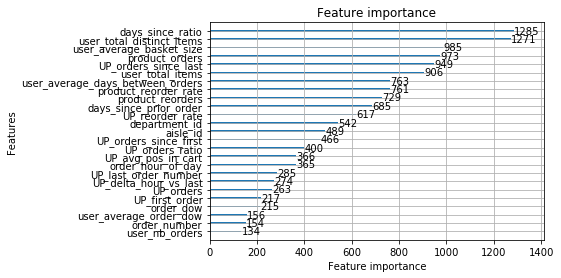

In [37]:
print('Plot feature importances...')
ax = lgb.plot_importance(bst, max_num_features=30)
plt.show()